In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..', 'code', 'python')))
sys.path.append(os.path.abspath(os.path.join('..', '..', 'code', 'python', 'common')))
import common.plots as plots
import scale_setters as scale_setters

In [3]:
def get_dir_names(path):
    directories = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        directories.extend(dirnames)
        break
    return directories

def concat_observables(df, observables):
    data = []
    for obs in observables:
        data.append(df.loc[:, ['box_size', 'radius', obs, f'{obs}_err']])
        data[-1] = data[-1].rename({obs: 'y', f'{obs}_err': 'err'}, axis=1)
        data[-1]['observable'] = obs
    return pd.concat(data)

def read_data(path, observables):
    df = pd.DataFrame()
    lattice_dirs = get_dir_names(path)
    for lattice in lattice_dirs:
        border_dirs = get_dir_names(f'{path}/{lattice}')
        for border in border_dirs:
            velocity_dirs = get_dir_names(f'{path}/{lattice}/{border}')
            for velocity in velocity_dirs:
                beta_dirs = get_dir_names(f'{path}/{lattice}/{border}/{velocity}')
                for beta in beta_dirs:
                    file_path = f'{path}/{lattice}/{border}/{velocity}/{beta}/observables_result.csv'
                    if os.path.isfile(file_path):
                        df_tmp = pd.read_csv(file_path, delimiter=' ')
                        df_tmp = concat_observables(df_tmp, observables)
                        df_tmp['velocity'] = float(velocity[:-1])
                        df_tmp['beta'] = float(beta)
                        df_tmp['border'] = border
                        df_tmp['lattice'] = lattice[:-2]
                        df = pd.concat([df, df_tmp])
    return df

In [4]:
def find_closest(val, arr, threshold):
    closest = None
    index = None
    diff_old = abs(arr.max() - arr.min())
    for i in range(len(arr)):
        diff_new = abs(val - arr[i])
        if diff_new < diff_old and diff_new / abs(val) < threshold:
            diff_old = diff_new
            closest = arr[i]
            index = i
    return closest, index

def group_T(T_arr, threshold):
    a = {}
    for i in range(len(T_arr)):
        while len(T_arr[i]) > 0:
            T_group = []
            T = T_arr[i][0]
            T_group.append(T)
            T_arr[i] = np.delete(T_arr[i], 0)
            for j in range(i + 1, len(T_arr)):
                closest, index = find_closest(T, T_arr[j], threshold)
                if closest is not None:
                    T = closest
                    T_group.append(closest)
                    T_arr[j] = np.delete(T_arr[j], index)
            T_mean = sum(T_group) / len(T_group)
            for t in T_group:
                a[t] = T_mean
    return a

In [5]:
beta_critical = {'nt4o': 4.088,
                 'nt5o': 4.225,
                 'nt6o': 4.350,
                 'nt7o': 4.470,
                 'nt4p': 4.073,
                 'nt5p': 4.202,
                 'nt6p': 4.318,
                 'nt7p': 4.417,
                 }

In [6]:
def plot_asymmetry(df):
    T = df.name[1]
    obs = df.name[0]
    plots.make_plot(df, 'velocity', 'y', 'observable', r'$\Omega$ (GeV)', r'A ($GeV^{4}$)', 'asymmetry' + r', $T/T_{c}$ = ' + f'{T:.2f}, ' + obs, '../../images/eos_rotation_imaginary/5x30x121sq/OBCb_cV', 'asymmetry', True, err='err', dashed_line_y=[0])

In [7]:
def group_df(df):
    # print(df)
    T_arr = []
    T_arr.append(df[df['nt'] == 7]['T'].to_numpy())
    T_arr.append(df[df['nt'] == 6]['T'].to_numpy())
    T_arr.append(df[df['nt'] == 5]['T'].to_numpy())
    T_arr.append(df[df['nt'] == 4]['T'].to_numpy())
    a = group_T(T_arr, 0.03)
    df['T'] = df['T'].apply(lambda x: a[x])
    return df

     box_size     radius         y       err       observable  velocity  beta  \
184        55  77.781746  0.028099  0.000021  Ae, a = 0.12 fm  1.057985  4.32   
184        55  77.781746 -0.088986  0.000022  Am, a = 0.12 fm  1.057985  4.32   
184        55  77.781746 -0.000008  0.000021  Ae, a = 0.12 fm  0.000000  4.32   
184        55  77.781746  0.000017  0.000019  Am, a = 0.12 fm  0.000000  4.32   
184        55  77.781746  0.020687  0.000020  Ae, a = 0.12 fm  0.885173  4.32   
184        55  77.781746 -0.066368  0.000015  Am, a = 0.12 fm  0.885173  4.32   
184        55  77.781746  0.018054  0.000018  Ae, a = 0.12 fm  0.819511  4.32   
184        55  77.781746 -0.058246  0.000017  Am, a = 0.12 fm  0.819511  4.32   
184        55  77.781746  0.009503  0.000020  Ae, a = 0.12 fm  0.579481  4.32   
184        55  77.781746 -0.031237  0.000018  Am, a = 0.12 fm  0.579481  4.32   
184        55  77.781746  0.006453  0.000019  Ae, a = 0.12 fm  0.473145  4.32   
184        55  77.781746 -0.

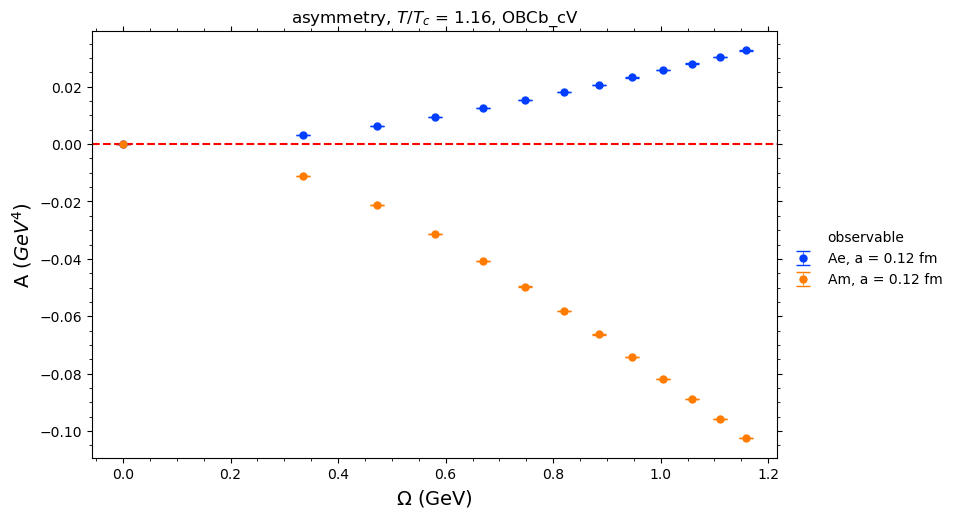

""


In [8]:
path = '../../result/eos_rotation_imaginary'
fm_to_GeV = 1/0.197327 # 1 fm = 1/0.197327 GeV ** -1
df = read_data(path, ['Ae', 'Am'])
df['nt'] = df['lattice'].apply(lambda x: int(x[:x.find('x')]))
df['ns'] = df['lattice'].apply(lambda x: int(x[x.rfind('x') + 1:]))
df = df[(df['box_size'] == df['ns'] // 2 - df['nt']) & (df['radius'] == (df['ns'] // 2 - df['nt']) * np.sqrt(2))]
scale_setter = scale_setters.ExtendedSymanzikScaleSetter()
df['a_GeV'] = scale_setter.get_spacing_in_fm(df['beta']) * fm_to_GeV
df['a_fm'] = scale_setter.get_spacing_in_fm(df['beta'])
df['border_brief'] = df['border'].apply(lambda x: x[0].lower())
df['beta_crit'] = df.apply(lambda x: beta_critical[f'nt{x['nt']}{x['border_brief']}'], axis=1)
df['a_crit'] = scale_setter.get_spacing_in_fm(df['beta_crit']) * fm_to_GeV
df['T'] = df['a_crit'] / df['a_GeV']
df['y'] = df['y'] * df['beta'] / 6 / df['a_GeV'] ** 4
df['err'] = df['err'] * df['beta'] / 6 / df['a_GeV'] ** 4
df['velocity'] = df['velocity'] / df['a_GeV']
df['y'] = -df['y']
# print(df)
# df = df.groupby(['border', 'velocity', 'observable']).apply(group_df, include_groups=False)
df['a_str'] = df['a_fm'].apply(lambda x: "%.2f" % x)
df['observable'] = df['observable'] + ', a = ' + df['a_str'] + ' fm'
print(df)
df.set_index(['border', 'T']).groupby(['border', 'T']).apply(plot_asymmetry, include_groups=False)
# plots.make_plot(df, 'velocity', 'y', 'observable', r'$\Omega$ (GeV)', r'A ($GeV^{4}$)', 'asymmetry', '../../images/eos_rotation_imaginary/5x30x121sq/OBCb_cV', 'asymmetry', True, err='err', dashed_line_y=[0], save_figure=True)

44
48
47
46
{np.float64(0.47065174460163894): np.float64(0.46852516005020095), np.float64(0.46639857549876296): np.float64(0.46852516005020095), np.float64(0.5054539844578365): np.float64(0.5043168708893517), np.float64(0.503179757320867): np.float64(0.5043168708893517), np.float64(0.5419641737931088): np.float64(0.5429394088183765), np.float64(0.5418077715398946): np.float64(0.5429394088183765), np.float64(0.545046281122126): np.float64(0.5429394088183765), np.float64(0.580243429882636): np.float64(0.5837492175197608), np.float64(0.5823613583402092): np.float64(0.5837492175197608), np.float64(0.5886428643364371): np.float64(0.5837492175197608), np.float64(0.6203517926372012): np.float64(0.6265674323013865), np.float64(0.6249166249659434): np.float64(0.6265674323013865), np.float64(0.634433879301015): np.float64(0.6265674323013865), np.float64(0.6623488911186062): np.float64(0.661934761722556), np.float64(0.6695474367459595): np.float64(0.661934761722556), np.float64(0.6581828444595349

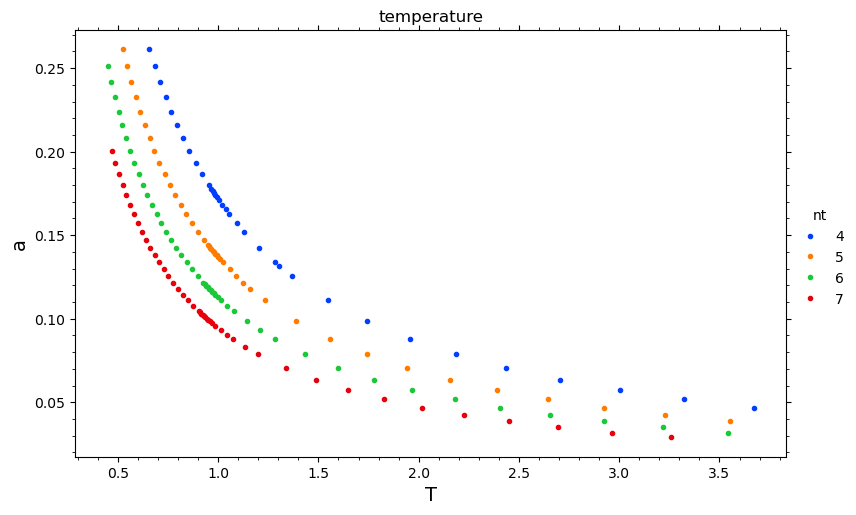

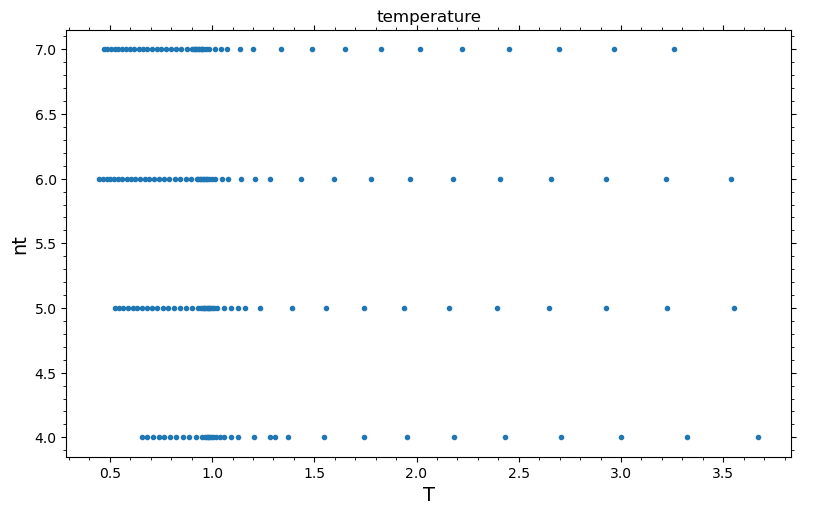

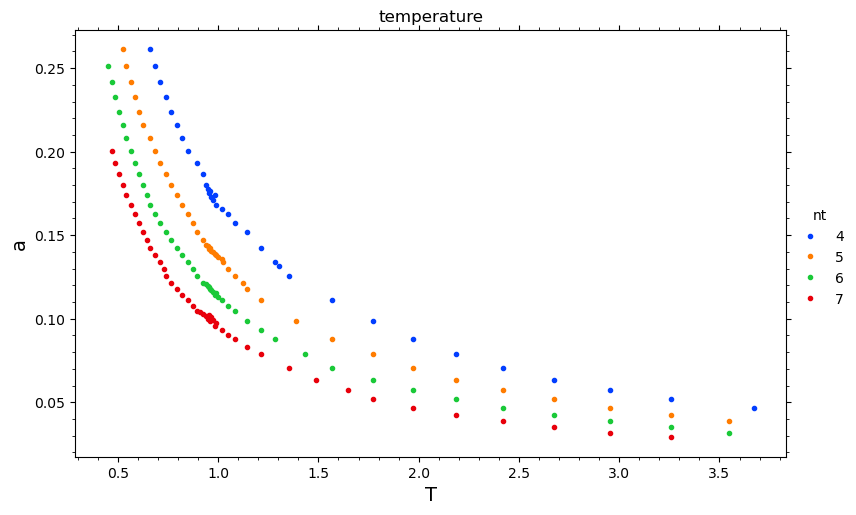

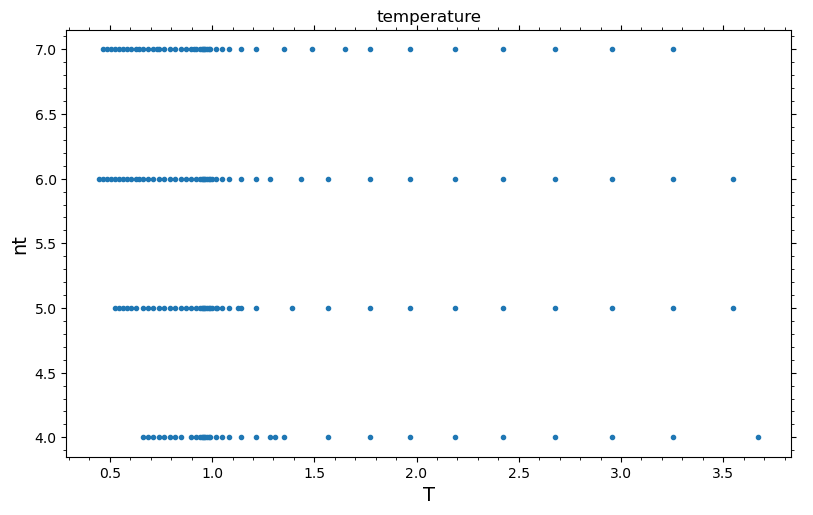

In [10]:
betas_nt4 = [3.6400, 3.6800, 3.7400, 3.8000, 3.8400, 3.8800, 3.9200, 3.9600, 4.0000, 4.0400, 4.0680, 4.0760, 4.0850, 4.1000, 4.1200, 4.1600, 4.2400, 4.2800, 4.4400, 4.6000, 4.7600, 4.9200,
3.6600, 3.7000, 3.7800, 3.8200, 3.8600, 3.9000, 3.9400, 3.9800, 4.0200, 4.0600, 4.0720, 4.0800, 4.0900, 4.1100, 4.1400, 4.2000, 4.2500, 4.3600, 4.5200, 4.6800, 4.8400, 5.0000]
betas_nt5 = [3.7600, 3.8000, 3.8400, 3.8800, 3.9200, 3.9600, 4.0000, 4.0400, 4.0800, 4.1200, 4.1600, 4.1920, 4.2000, 4.2080, 4.2160, 4.2250, 4.2400, 4.2800, 4.3200, 4.4400, 4.6000, 4.7600, 4.9200, 5.0800,
3.7800, 3.8200, 3.8600, 3.9000, 3.9400, 3.9800, 4.0200, 4.0600, 4.1000, 4.1400, 4.1800, 4.1960, 4.2040, 4.2120, 4.2200, 4.2300, 4.2600, 4.3000, 4.3600, 4.5200, 4.6800, 4.8400, 5.0000, 5.1600]
betas_nt6 = [3.8800, 3.9200, 3.9600, 4.0000, 4.0400, 4.0800, 4.1200, 4.1600, 4.2000, 4.2400, 4.2800, 4.3050, 4.3150, 4.3250, 4.3350, 4.3500, 4.3800, 4.4400, 4.5200, 4.6800, 4.8400, 5.0000, 5.1600, 5.3200,
3.9000, 3.9400, 3.9800, 4.0200, 4.0600, 4.1000, 4.1400, 4.1800, 4.2200, 4.2600, 4.3000, 4.3100, 4.3200, 4.3300, 4.3400, 4.3600, 4.4000, 4.4800, 4.6000, 4.7600, 4.9200, 5.0800, 5.2400]
betas_nt7 = [4.0000, 4.0400, 4.0800, 4.1200, 4.1600, 4.2000, 4.2400, 4.2800, 4.3200, 4.3600, 4.4000, 4.4100, 4.4200, 4.4300, 4.4400, 4.4600, 4.5000, 4.5600, 4.6800, 4.8400, 5.0000, 5.1600, 5.3200,
4.0200, 4.0600, 4.1000, 4.1400, 4.1800, 4.2200, 4.2600, 4.3000, 4.3400, 4.3800, 4.4050, 4.4150, 4.4250, 4.4350, 4.4500, 4.4800, 4.5200, 4.6000, 4.7600, 4.9200, 5.0800, 5.2400, 5.4000]
print(len(betas_nt4))
print(len(betas_nt5))
print(len(betas_nt6))
print(len(betas_nt7))
df = []
df.append(pd.DataFrame({'beta': betas_nt4}))
df[-1]['nt'] = 4
df.append(pd.DataFrame({'beta': betas_nt5}))
df[-1]['nt'] = 5
df.append(pd.DataFrame({'beta': betas_nt6}))
df[-1]['nt'] = 6
df.append(pd.DataFrame({'beta': betas_nt7}))
df[-1]['nt'] = 7
df = pd.concat(df)
scale_setter = scale_setters.ExtendedSymanzikScaleSetter()
df = df[df['beta'] >= 3.85]
df['a'] = scale_setter.get_spacing_in_fm(df['beta'])
df['beta_crit'] = df['nt'].apply(lambda x: beta_critical[f'nt{x}o'])
df['a_crit'] = scale_setter.get_spacing_in_fm(df['beta_crit'])
df['T'] = df['a_crit'] / df['a']
# df = df[df['T'] > 3]
T_arr = []
T_arr.append(df[df['nt'] == 7]['T'].to_numpy())
T_arr.append(df[df['nt'] == 6]['T'].to_numpy())
T_arr.append(df[df['nt'] == 5]['T'].to_numpy())
T_arr.append(df[df['nt'] == 4]['T'].to_numpy())
a = group_T(T_arr, 0.03)
print(a)
print(df)
df_tmp = df[df['nt'] == 5]
print(df_tmp[['beta', 'T']].to_string())
plots.make_plot(df, 'T', 'a', 'nt', 'T', 'a', 'temperature', '../../images/eos_rotation_imaginary/5x30x121sq/OBCb_cV', 'asymmetry', show_plot=True)
plots.make_plot(df, 'T', 'nt', None, 'T', 'nt', 'temperature', '../../images/eos_rotation_imaginary/5x30x121sq/OBCb_cV', 'asymmetry', show_plot=True)
df['T'] = df['T'].apply(lambda x: a[x])
plots.make_plot(df, 'T', 'a', 'nt', 'T', 'a', 'temperature', '../../images/eos_rotation_imaginary/5x30x121sq/OBCb_cV', 'asymmetry', show_plot=True)
plots.make_plot(df, 'T', 'nt', None, 'T', 'nt', 'temperature', '../../images/eos_rotation_imaginary/5x30x121sq/OBCb_cV', 'asymmetry', show_plot=True)